In [154]:
import numpy as np
import pandas as pd
import os
#print(os.listdir("../input"))
from re import sub
from decimal import Decimal
from sklearn.preprocessing import MultiLabelBinarizer
from scipy import stats
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Introduction

Bevore we use the data we have to understand what is the data describing and how is it come to be.
I 'skipped' the data cleaning part, there for I will explain what happened with the data and why.


## Data Source

The data input for this project was provided by AirBnb over Kaggle promoted by Udacity:
- for the Seattle data: https://www.kaggle.com/airbnb/seattle/data
- for the Boston data: https://www.kaggle.com/airbnb/boston

The data contained about 3818 rows and 92 columns for the Seattle dataset and 3585 rows and 95 columns for the dataset from Boston. not all columns were filled in both sets and I somewhat followed the suggestion from the cleaning project concerning the columns I put the focus on. 

The cleaning of the data was done by following a post from Daniel Koo et Al.:
https://www.kaggle.com/kernels/scriptcontent/12321941/download

## Cleaning Focus

The cleaning of the data focused on the columns which seamed to hold the most constant and intresting information about the places. Columns about the precisson of the GPS coordinates, the booking frequency, the date of the last update and the like have been droped.

## Datatypes

### Categorical Data

The choosen categorical columns:
- 'host_is_superhost': boolean like f/t
- 'property_type': up to 16 levels
- 'room_type': entire home/shared room/private room
- 'bed_type': 5 levels
- 'amenities': full text listing of all availiable amenities
- 'price': price in text format '\$100.00' -> will be quantitative after processing
- 'cleaning_fee': cleaning fee in text format '\$100.00' -> will be quantitative after processing
- 'instant_bookable': boolean like f/t
- 'cancellation_policy': up to 4 levels of strictness


### Quantitative Data

The choosen quantitative columns:
- 'id': for reference to the ratings dataset
- 'latitude': GPS latitude
- 'longitude': GPS longitude
- 'guests_included': 0 - 14
- 'bathrooms': 1.0 - 8.0 in 0.5 steps
- 'bedrooms':  1 - 7
- 'beds': 1 - 16
- 'city': boston or seattle
- 'review_scores_value': scores from 0 to 10

### Ratings Dataset

From the ratings dataset:
- 'id': reference to the listings dataset
- 'comments': full text data

### Missing Data

With only cleaning_fee and review_scores_value having many missing values indicating that there is no cleaning fee or there was no rating given for the specific places all nans were filled with '0'. For later it is important to remember 0 dosnt mean very bad it means there is no rating.
The Resulting combined dataset has 7347 rows.

## Data Transformations

### Format Transformations

host_is_superhost and instant_bookable have been transformed to t = 1 and f = 0. price and cleaning_fee have been transformed from string to float.


### Dummied Columns

room_type, property_type, bed_type, cancellation_policy have been transformed into dummy columns.

### Normalised Columns

all non binary (not the dummies) have been max-min-normalized. 

## Creating Advanced Data

A new column was created out of the longitude and latitude columns stating the distance to the cities main airport.

## Cleaning result

After all the cleaning I got 6872 rows

## Data Merging

The Kaggle notebok I used was originaly designed only for the Seattle dataset. I changed it to include the Boston dataset and to compute the distance to the given cities airport and included the rating value and a value for the two cities.

# Analysis Focus

## Qestions to be answered

Which are the most significant features influencing the price?

Which are the most significant features influencing the review score?

Is there a big difference ansewering these questions for the two cities seperatly?


# Into the Data

What do we have, lets look inside

In [293]:
df = pd.read_csv('airbnb_data.csv')

df.head()

,listing_id,comments,host_is_superhost,guests_included,bathrooms,bedrooms,beds,price,cleaning_fee,instant_bookable,...,suitable_for_events,translation_missing:_en.hosting_amenity_49,translation_missing:_en.hosting_amenity_50,tv,washer,washer_/_dryer,wheelchair_accessible,wireless_internet,boston,seattle
0,3353,"[['giuseppe', 'nice', 'cordial', 'host', 'room...",0,0.066667,0.125,0.142857,0.0625,0.007519,0.166667,0,...,0,1,1,0,1,0,0,1,1,0
1,4291,"[['great', 'place', 'would', 'love', 'stay'], ...",0,0.066667,0.125,0.142857,0.0625,0.018045,0.100000,0,...,0,0,0,1,1,0,0,1,0,1
2,5506,"[['warm', 'accommodating', 'host', 'beautiful'...",0,0.133333,0.125,0.142857,0.0625,0.033835,0.133333,0,...,0,0,0,1,1,0,0,1,1,0
3,5682,"[['studio', 'clean', 'comfortable', 'nice', 'n...",0,0.066667,0.125,0.142857,0.0625,0.009524,0.083333,1,...,0,0,0,1,0,0,0,1,0,1
4,6606,"[['first', 'time', 'seattle', 'loved', 'proxim...",0,0.133333,0.125,0.142857,0.0625,0.020050,0.133333,0,...,0,0,0,1,0,0,0,1,0,1


In [84]:
df.columns

Index(['listing_id', 'comments', 'host_is_superhost', 'guests_included',
       'bathrooms', 'bedrooms', 'beds', 'price', 'cleaning_fee',
       'instant_bookable', 'review_scores_value', 'Apartment',
       'Bed & Breakfast', 'Boat', 'Bungalow', 'Cabin', 'Camper/RV', 'Chalet',
       'Condominium', 'Dorm', 'Entire Floor', 'Guesthouse', 'House', 'Loft',
       'Other', 'Tent', 'Townhouse', 'Treehouse', 'Villa', 'Yurt',
       'Entire home/apt', 'Private room', 'Shared room', 'Airbed', 'Couch',
       'Futon', 'Pull-out Sofa', 'Real Bed', 'flexible', 'moderate', 'strict',
       'super_strict_30', 'd_airport', 'Unnamed: 44', '24-hour_check-in',
       'air_conditioning', 'breakfast', 'buzzer/wireless_intercom', 'cable_tv',
       'carbon_monoxide_detector', 'cat(s)', 'dog(s)', 'doorman', 'dryer',
       'elevator_in_building', 'essentials', 'family/kid_friendly',
       'fire_extinguisher', 'first_aid_kit', 'free_parking_on_premises',
       'free_parking_on_street', 'gym', 'hair_dryer'

In [85]:
df.dtypes

listing_id                                      int64
comments                                       object
host_is_superhost                               int64
guests_included                               float64
bathrooms                                     float64
bedrooms                                      float64
beds                                          float64
price                                         float64
cleaning_fee                                  float64
instant_bookable                                int64
review_scores_value                           float64
Apartment                                       int64
Bed & Breakfast                                 int64
Boat                                            int64
Bungalow                                        int64
Cabin                                           int64
Camper/RV                                       int64
Chalet                                          int64
Condominium                 

City is encoded, so we drop it

In [ ]:
df = df.drop(['city'], 1)

Lets plot the proportions of all categorical features

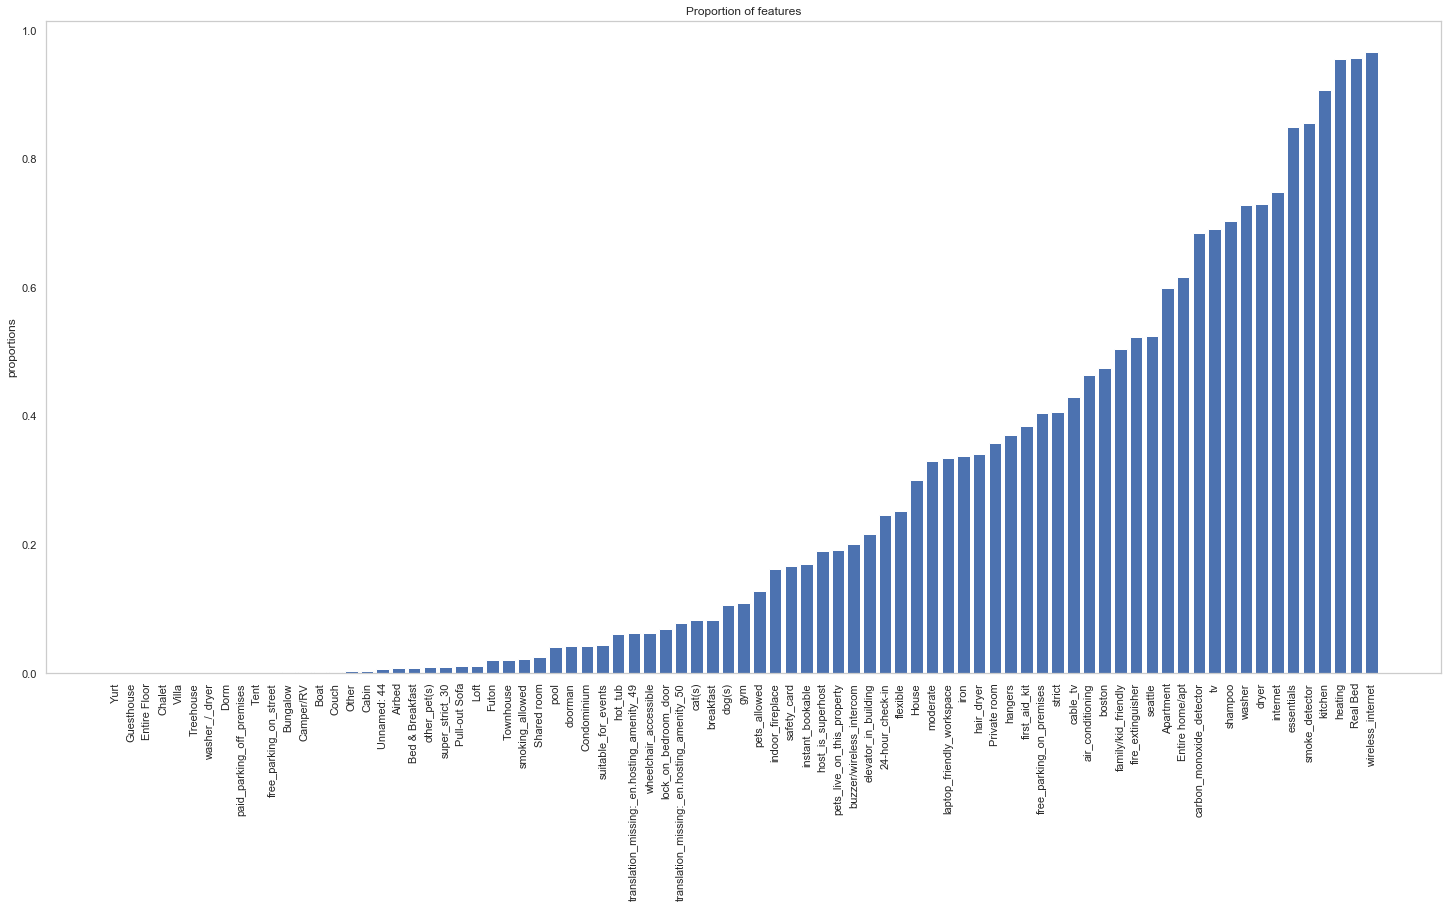

In [295]:
counts = df.drop(['listing_id'],1).select_dtypes(include=['int64']).sum()/len(df)
counts=counts.sort_values()
plt.figure(figsize=(25,12))
plt.xticks(np.arange(len(counts)),counts.index,rotation='vertical')
plt.ylabel('proportions')
plt.title('Proportion of features')
plt.grid()
plt.bar(np.arange(len(counts)),counts);

Lets look at the proportions splitted by the cities

In [301]:
def get_proportion_counts(df,split_feature, dont_include_features):
    '''
    calculates a pandas series holding the feature names an the proportions spit by the given grouping column
    
    INPUT: df - a dataframe,
    split_feature - feature name as string on wich the result will be filtered by df[df[split_feature]==1]
    dont_include_features - list of features which will be ignored in the result e.g. id columns
    
    OUTPUT: Pandas series with the proportion for each column not in the ignore list having type 'int64'
    '''
    return df[df[split_feature]==1].drop(dont_include_features,1).select_dtypes(include=['int64']).sum()/len(df[df[split_feature]==1])

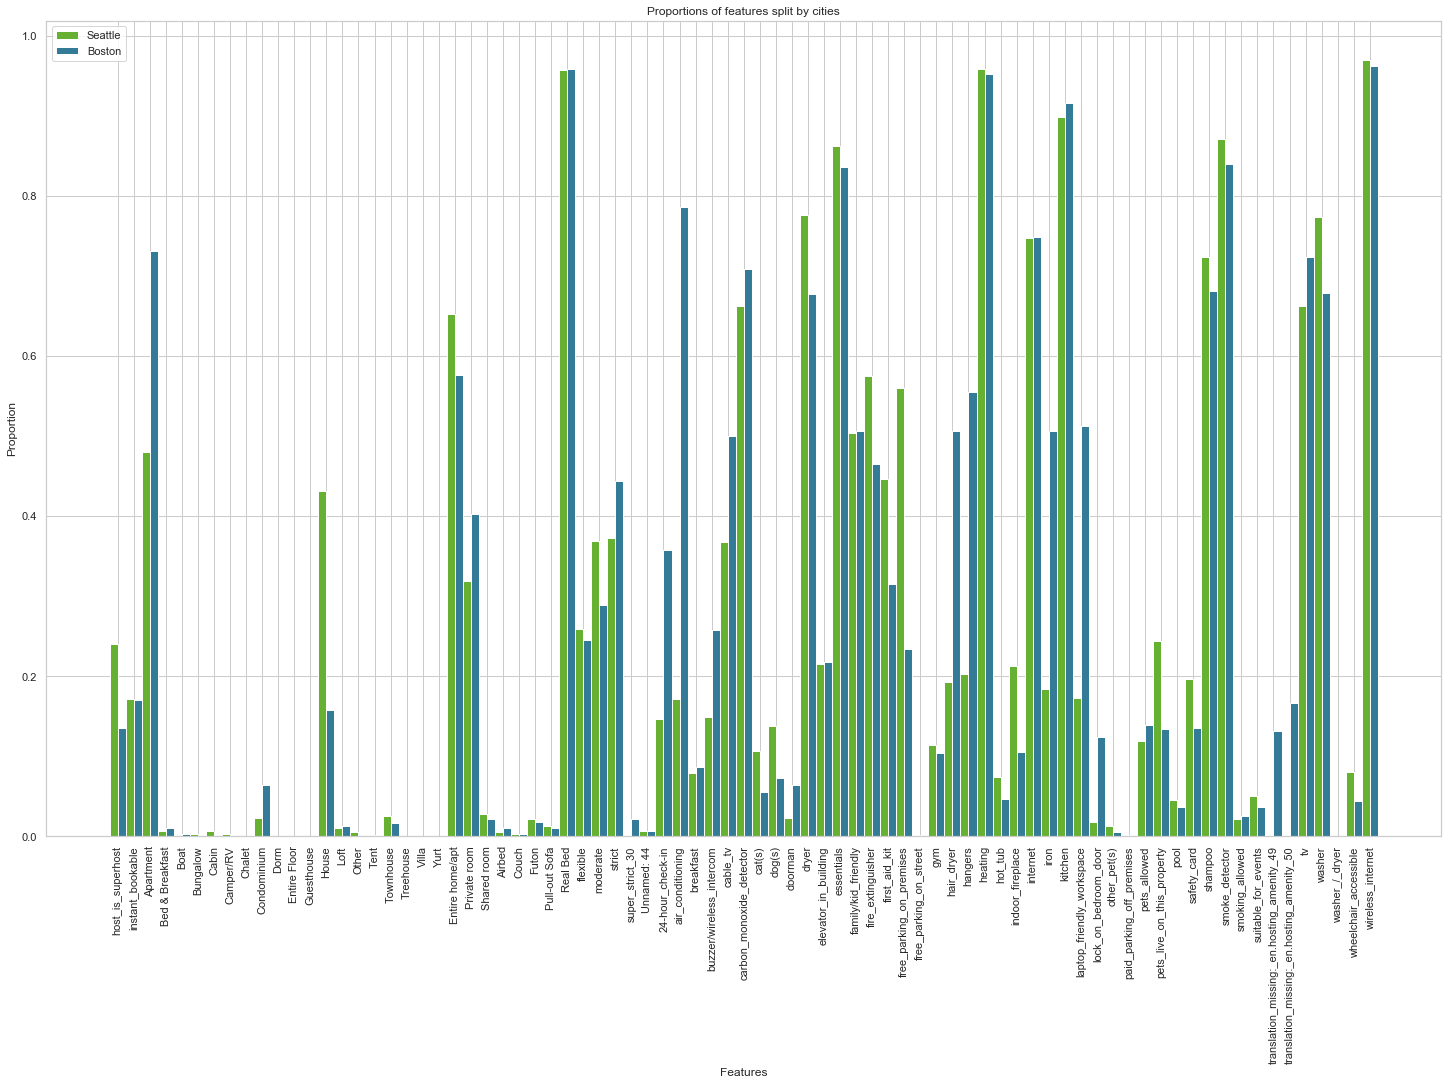

In [302]:
seattle_counts = get_proportion_counts(df = df, split_feature='seattle', dont_include_features=['listing_id','boston','seattle'])
boston_counts = get_proportion_counts(df = df, split_feature='boston', dont_include_features=['listing_id','boston','seattle'])


plt.figure(figsize=(25,15))
plt.xticks(np.arange(len(seattle_counts))+0.25, seattle_counts.index, rotation='vertical')
plt.bar(np.arange(len(seattle_counts)),seattle_counts, color='#66B032',width = 0.5, label='Seattle')         
plt.bar(np.arange(len(boston_counts))+0.5,boston_counts, color='#347B98',width = 0.5, label='Boston')
plt.xlabel('Features')
plt.ylabel('Proportion')
plt.legend()
plt.title('Proportions of features split by cities')
plt.show()

Whats the mean score split by city

In [286]:
print('Seattle score mean: {}'.format(df.query('review_scores_value > 0.0 and boston == 0')['review_scores_value'].mean()))
print('Boston score mean: {}'.format(df.query('review_scores_value > 0.0 and boston == 1')['review_scores_value'].mean()))

Seattle score mean: 0.9456955922865165
Boston score mean: 0.9178736517719689


Lets describe the continous numeric data

In [89]:
df.select_dtypes(include=['float']).describe()

,guests_included,bathrooms,bedrooms,beds,price,cleaning_fee,review_scores_value,d_airport
count,5587.000000,5587.000000,5587.000000,5587.000000,5587.000000,5587.000000,5587.000000,5587.000000
mean,0.097309,0.144286,0.165614,0.094774,0.030832,0.140226,0.918042,0.409159
std,0.058230,0.046334,0.091233,0.047741,0.019632,0.150545,0.145404,0.251531
min,0.000000,0.000000,0.000000,0.000000,0.000251,0.000000,0.000000,0.000000
25%,0.066667,0.125000,0.142857,0.062500,0.016291,0.000000,0.900000,0.166492
50%,0.066667,0.125000,0.142857,0.062500,0.025063,0.100000,0.900000,0.377239
75%,0.133333,0.125000,0.142857,0.125000,0.040100,0.200000,1.000000,0.590297
max,0.333333,0.312500,0.428571,0.250000,0.124311,1.000000,1.000000,1.000000


What are the Ratings split by the features?

In [304]:
def get_mean_df(df, score_name, ignore_column):
    '''
    calculates the mean for each feature in the given dataframe
    
    INPUT: df - pandas dataframe
    score_name - name of the continous numerical column on which the mean is calculated for all categorical features
    ignore_column - int64 column to be ignored like the id column
    
    OUTPUT: pandas dataframe with the mean score for each feature
    '''
    df_diag = pd.DataFrame()
    
    for col in df.select_dtypes(include=['int64']).drop(ignore_column,1).columns:
        df_diag[col] = [df[df[col]==1][score_name].mean()]
    df_diag = df_diag.sum().sort_values()
    return df_diag

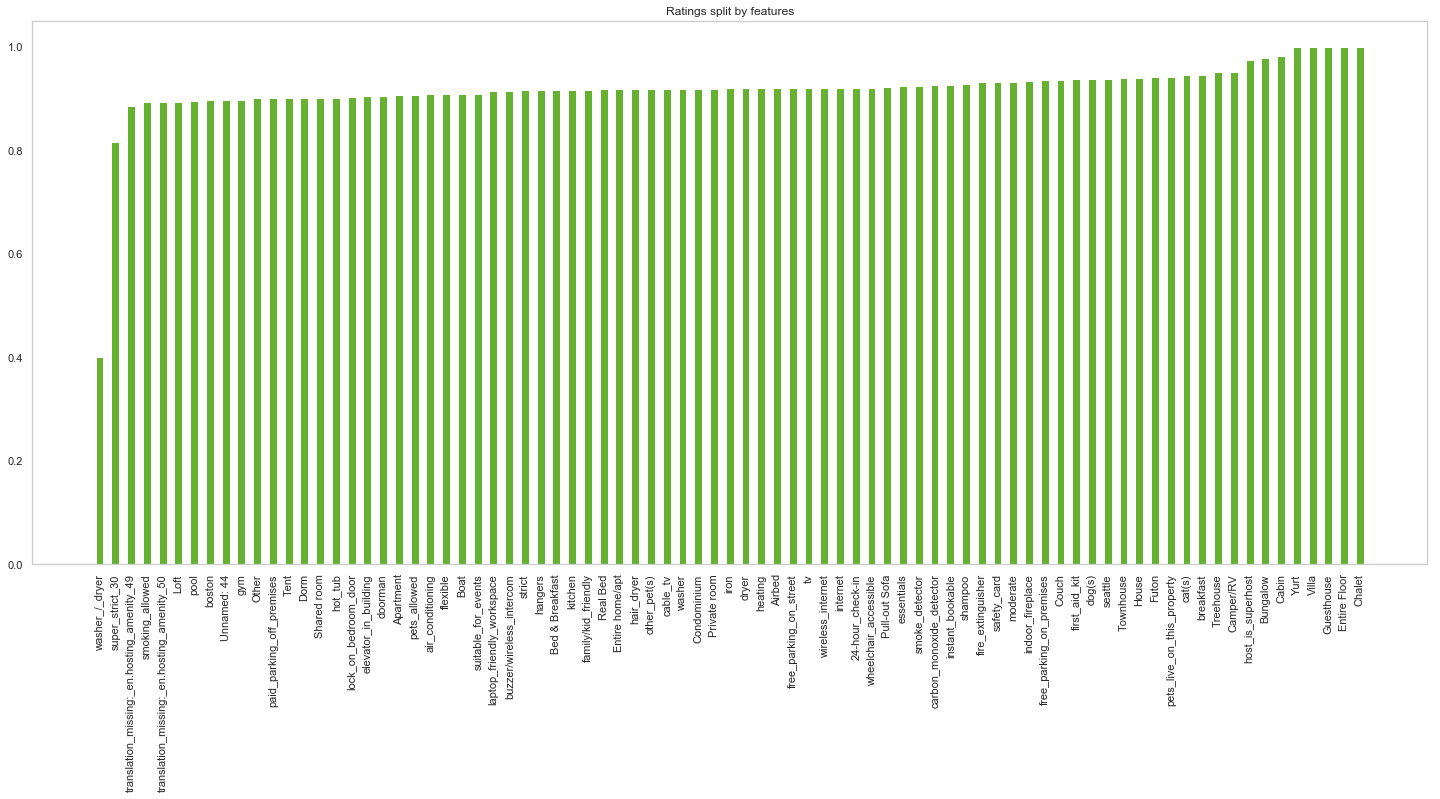

In [306]:
df_diag = get_mean_df(df,'review_scores_value', 'listing_id')

plt.figure(figsize=(25,10))
plt.xticks(np.arange(len(df_diag)), df_diag.index, rotation='vertical')
plt.bar(np.arange(len(df_diag)),df_diag, color='#66B032',width = 0.5)         
plt.title('Ratings split by features')
plt.grid()
plt.show()

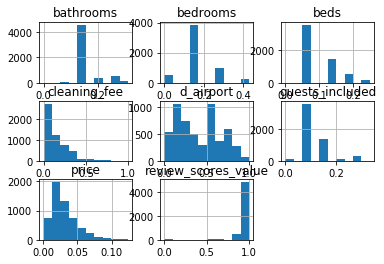

In [118]:
df.select_dtypes(include=['float']).hist();

What about the corellation between all float data

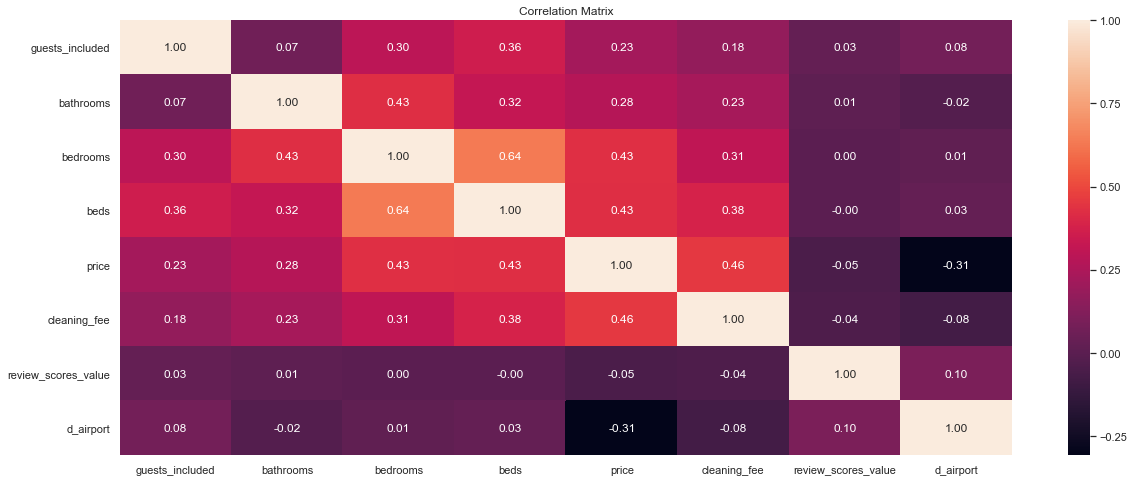

In [288]:
plt.figure(figsize=(20,8))
sns.heatmap(df.select_dtypes(include=['float']).corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix');

Next is the visualization of the distance to the next main airport by price and review score

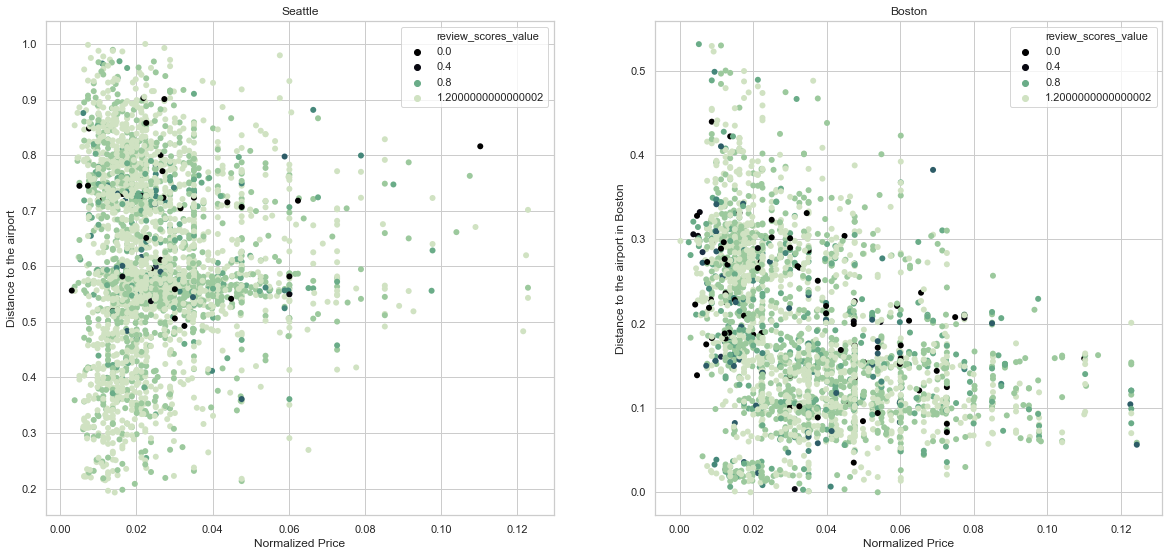

In [292]:
plt.figure(figsize=(20,20))
plt.subplot(221)
sns.scatterplot(x='price',
                y='d_airport',
                hue='review_scores_value',
                palette="ch:r=-.5,d=-.5_r",
                linewidth=0,data=df.query('boston == 0')[['price', 'd_airport','review_scores_value']],
                hue_order=[0,1])
plt.ylabel('Distance to the airport')
plt.xlabel('Normalized Price')
plt.title('Seattle')
plt.subplot(222)
sns.scatterplot(x='price',
                y='d_airport',
                hue='review_scores_value',
                palette="ch:r=-.5,d=-.5_r",
                linewidth=0,data=df.query('boston == 1')[['price', 'd_airport','review_scores_value']],
                hue_order=[0,1])
plt.ylabel('Distance to the airport in Boston')
plt.xlabel('Normalized Price')
plt.title('Boston')
plt.show()

Summing up and scaling the difference to the total mean score and price

In [227]:
'''
In this part the diff of the score and the review rating to its total mean is calculated and saved into a dataframe with a row for each of those two
'''
df_diff = pd.DataFrame()
df_1 = df.select_dtypes(include=['int64']).drop('listing_id',1)

for col in df_1.columns:
    df_diff[col] = [(df[df[col]==1]['review_scores_value'] - df[df[col]==1]['review_scores_value'].mean()).sum(),
                    (df[df[col]==1]['price'] - df[df[col]==1]['price'].mean()).sum()]

df_diff['legend'] = ['review_scores_value','price']

df_diff

,host_is_superhost,instant_bookable,Apartment,Bed & Breakfast,Boat,Bungalow,Cabin,Camper/RV,Chalet,Condominium,...,translation_missing:_en.hosting_amenity_49,translation_missing:_en.hosting_amenity_50,tv,washer,washer_/_dryer,wheelchair_accessible,wireless_internet,boston,seattle,legend
0,3.937739e-12,6.012968e-12,-6.717915e-11,1.709743e-14,5.551115e-16,-6.661338e-16,-1.332268e-15,5.551115e-16,0.0,-3.788081e-13,...,-4.316547e-13,1.030287e-13,-8.600853e-11,-9.380940e-11,0.0,-8.615331e-14,-3.637624e-11,-3.117151e-11,-4.386458e-11,review_scores_value
1,4.596323e-14,1.310063e-14,-5.673240e-13,2.046974e-16,-1.249001e-16,-1.561251e-17,-7.632783e-17,-1.734723e-18,0.0,-5.773160e-15,...,4.551914e-15,-2.220446e-15,-1.025402e-12,-7.798207e-13,0.0,-6.661338e-15,-5.566658e-13,-3.539391e-13,-1.411093e-13,price


In [ ]:
'''
We melt the dataframe so that we have one row for each diff value seperated by score and price
than we sort it by their value
'''
df_diff_t =pd.melt(df_diff, id_vars=['legend'], value_vars=df_diff.drop('legend',1).columns)
df_diff_t = df_diff_t.sort_values('value')

In [316]:
split = df_diff_t['legend'].unique()
for n, name in enumerate(split):
    print(name)
    print(n)

review_scores_value
0
price
1


In [361]:
def nomalize_by_absmax(df_t, split_column, value_column):
    '''
    normalizing all values to the groupings abs maximum
    
    INPUT: 
    df_t - datatrame with columns for features, grouping and value
    split_column - string name of the grouping column
    value_column - string name of the column holding the values
    
    OUTPUT:
    dataframe
    '''
    df_diff_t_n = []
    split = df_diff_t[split_column].unique()
    for n, name in enumerate(split):
        df_diff_t_n.append(df_t[df_t[split_column]==name].copy())
        max_val = df_diff_t_n[n][value_column].abs().max()
        df_diff_t_n[n][value_column]=df_diff_t_n[n][value_column].apply(lambda x: x/max_val if x>=0 else x/max_val)
    
    conc = df_diff_t_n.pop()
    for df in df_diff_t_n:
        conc = pd.concat([df,conc], ignore_index=True)
    return conc

In [362]:
df_diff_t_n = nomalize_by_absmax(df_diff_t,'legend','value')

With the processed data now we can plot thr result

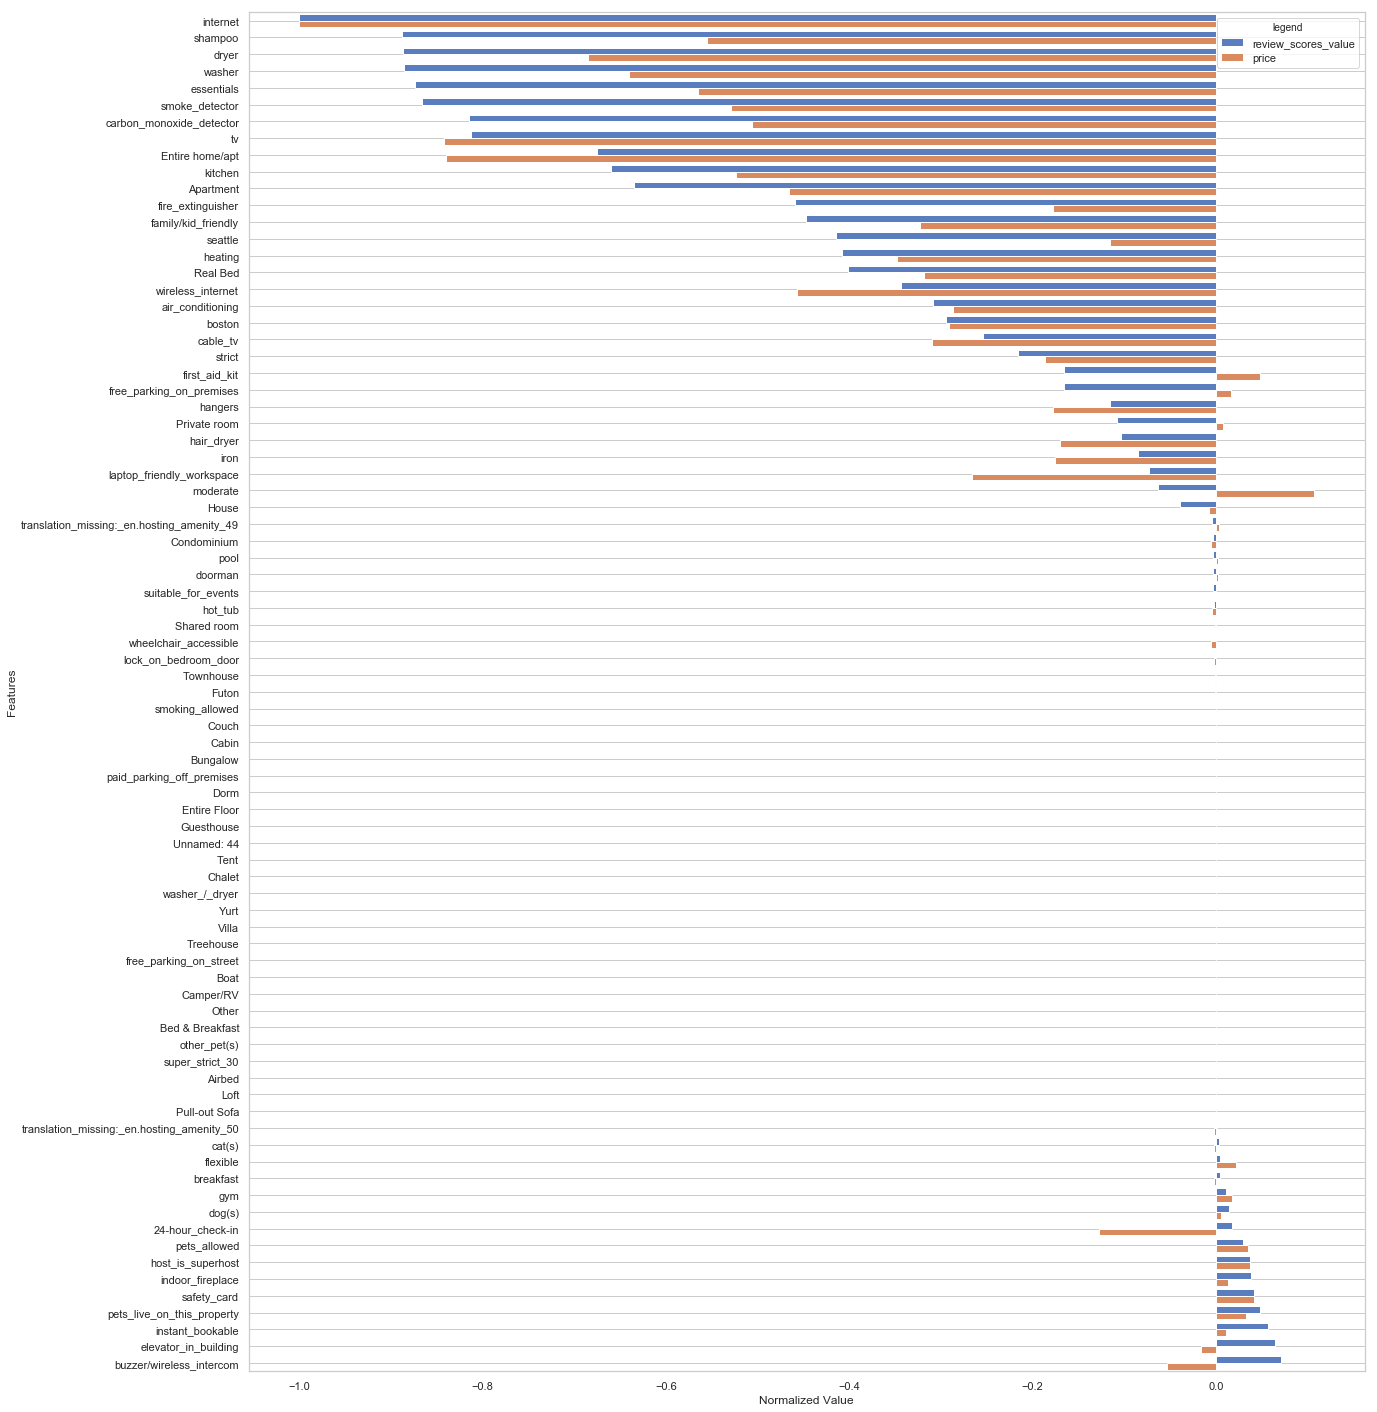

In [363]:
plt.figure(figsize=(20,25))
sns.set(style="whitegrid")
sns.barplot(x='value',y='variable',hue='legend', data = df_diff_t_n, palette='muted')
plt.xlabel('Normalized Value')
plt.ylabel('Features')
plt.grid()